## Adiabatic parameters from neutron's paths
Emma Klemets   
Nov. 2022   
Full documentation of the theory can be found at: https://www.overleaf.com/read/rfkkhhwwfjct

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
from numpy import linalg as LA
import pandas as pd
import seaborn as sns

In [3]:
#importing physical constants that are useful from scipy.constants
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
g_n = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0]
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

In [4]:
#3.11 in Pierre
def K_equ_dbdt(B, dbdt):
    return gamma_n*B**2 / dbdt

#equation 2 in the CDR - Sect 4.1 for the value of k
#3.12 in Pierre
def K_equ_dbdx(B, db_perpdx, v_n):
    return gamma_n*B**2 / (v_n*db_perpdx)

#3.14 in Pierre
def K_equ3_14(v_vec, B_1, B_2, r_1, r_2):
    #what to use for this value of the field?
    B = LA.norm(B_1)
    
    v_n = LA.norm(v_vec)
    B_1_norm = LA.norm(B_1)
    B_2_norm = LA.norm(B_2)
    
    #the angle that the field changes by
    if B_1_norm == 0 or B_2_norm == 0: # if either 0 feild == bad, k=0
        k = 0
    elif B_1_norm*B_2_norm == 0:  #not so sure about this one
        '''
        if either norm is 0, then bad
        '''
#         print(B_1_norm, B_2_norm)
        k = 0 #-np.inf
    else:
        theta = np.arccos(B_1@B_2/(B_1_norm*B_2_norm))
    
        #the distance for that change
        delta_distance = LA.norm(r_2 - r_1)

        #k calculation
        k = gamma_n*B*delta_distance / (v_n * theta)

    return k

[11-10 8:41 a.m.] Jeffery W. Martin
Also, just to set a scale for this problem:

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the UCN moves in a straight line at 8 m/s.

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the magnetic field rotates by 90 degrees during this time.

[11-10 8:43 a.m.] Jeffery W. Martin
Actually, let's say it rotates by 90 degrees in the course of 1 m of travel by the neutron.

[11-10 8:43 a.m.] Jeffery W. Martin
And let's say the value of the field is typically 1 mT.

[11-10 8:43 a.m.] Jeffery W. Martin
For this situation, I get k=15,000



In [5]:
#trying out Jeff's numbers, matches up
v_vec = np.array([8, 0, 0]) #m/s

B_1 = np.array([1, 0, 0])*1e-6 #=1uT
B_2 = np.array([0, 1, 0])*1e-6 #=1uT
r_1 = np.array([0, 0, 0]) 
r_2 = np.array([1, 0, 0]) #dx = 1m

K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

14.582346536127906

In [6]:
#calculates the k value for a 90 degrees turn with a uniform magnitude magnetic field (B)
#for a given neutron speed (vn) and distance of the turn (dx) 
def pseudoScalar_K_equ3_14(vn, B, dx):
    
    v_vec = np.array([vn, 0, 0])
    B_1 = np.array([B, 0, 0])
    B_2 = np.array([0, B, 0])
    r_1 = np.array([0, 0, 0]) 
    r_2 = np.array([dx, 0, 0])

    return K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

In [7]:
#scalar imputs for simplicity
#speed of your neutrons
vn = 8 #/ms
#magnitude of your magnetic field
B = 500*1e-6
#distance travels during the turn
dx = .2

pseudoScalar_K_equ3_14(vn, B, dx)

1458.234653612791

In [13]:
n = 55
B_arr = np.linspace(1e-6, 550e-6, n)
dx_arr = np.linspace(.01, .55, n)

k_array = np.empty((0, 3))
for B in B_arr:
    for dx in dx_arr:
        val = pseudoScalar_K_equ3_14(vn, B, dx)
        k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
# print(k_array)

In [14]:
df = pd.DataFrame(k_array, columns = ['B','dx','k'])
df = df.pivot("B", "dx", "k")

df = df.reindex(index=df.index[::-1])
# df

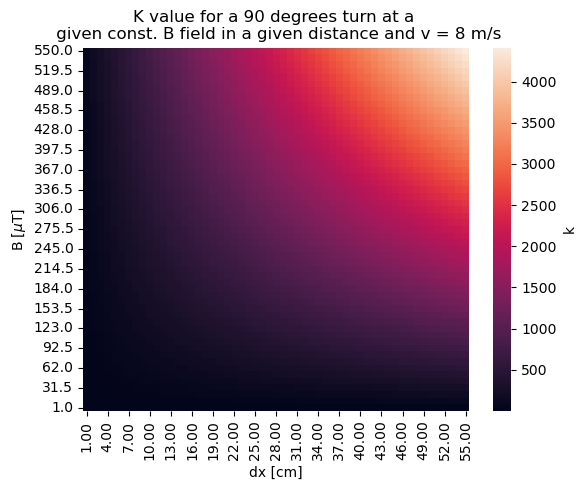

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))
q = sns.heatmap(df)#xticklabels=10, yticklabels=10, cmap=new_purple, linewidths=0, square=True)
    
ax.collections[0].colorbar.set_label("k")

# Add axis tick labels
# ax.set_xticks(np.arange(len(df.columns)), 
#               labels=np.round(df.columns, decimals=3))

# ax.set_yticks(np.arange(len(df.index)), 
#               labels=np.round(df.index*1e6, decimals=2))

# format text labels
fmt = '{:0.2f}' #dx
xticklabels = []
for item in ax.get_xticklabels():
    # print(item.get_text())
    item.set_text(fmt.format(float(item.get_text())*100))
    xticklabels += [item]
    
fmt = '{:0.1f}'
#B
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())*1e6))
    yticklabels += [item]
    
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)#,  rotation=0)

ax.set_xlabel("dx [cm]")
ax.set_ylabel("B [$\mu$T]")

ax.set_title("K value for a 90 degrees turn at a \n given const. B field in a given distance and v = 8 m/s")#, size=20)

fig.tight_layout()
plt.show()

# An idea of the B field
We have a lot of different regions, with different things that will affect the field:
 * SCM - well mapped
 * SSA - ?
 * Sheilding blocks - very much going to change
 * AMC - still in development, 
 * Background cylotron field - dipole analytic model
 * etc
 
 We need to start simpler than this.
 
 <img src="./Photos/guidingFieldDiagram.jpg" width="700" />

## Analytic Dipole model

The background field from the cylotron has been previously modeled usin an analytic dipole model for the potential, $\Phi_{dipole}$ and then using $\vec{B} = -\nabla \Phi_{dipole}$ to get the resulting magnetic field.

From the TUCAN 2022 status report: 12.1.3 Recent progress
Refined FEA simulation of the background magnetic field and compensating fields.

> The cyclotron stray field was approximated by a dipole field originated at (x, y) ≈ (−16m,−11m) away
from the center of the MSR and implemented to the FEA simulation.
- this is done with the center of the MSR as the origin
- only reproduces the major features of the field well for z > 0, and around the MSR

In [46]:
from sympy.vector import CoordSys3D, gradient

In [47]:
#should stick all this messing sympy stuff in a function 
# def DipoleFeild(x, y, z):
    

In [42]:
#define a coordinate system to use
R = CoordSys3D('F_{MSR}') 
M = sp.symbols("M_v")
x0,y0, z0 = sp.symbols(" x_0  y_0 z_0")

#the dipole function for the scalar potential
Phi = sp.Function("\Phi_{dipole}")(M, R.x, x0,R.y, y0,R.z, z0 )
Phi_funct = -M*(R.z-z0) / ((R.x-x0)**2 + (R.y-y0)**2 +(R.z-z0)**2)**(3/2)

display(sp.Eq(Phi, Phi_funct, evaluate=False))

Eq(\Phi_{dipole}(M_v, F_{MSR}.x, x_0, F_{MSR}.y, y_0, F_{MSR}.z, z_0), -M_v*(F_{MSR}.z - z_0)/((F_{MSR}.x - x_0)**2 + (F_{MSR}.y - y_0)**2 + (F_{MSR}.z - z_0)**2)**1.5)

In [43]:
# The fit parameters from Takashi's work
M_fit = -1.577 #T·m^3
x0_fit = -16.03 #m
y0_fit = -10.52 #m
z0_fit = 0.531 #m 

Phi_funct = Phi_funct.subs(M, M_fit).subs(x0, x0_fit).subs(y0, 
                        y0_fit).subs(z0, z0_fit) 

Phi_funct

0.000382852181685233*(F_{MSR}.z - 0.531)/((0.0623830318153462*F_{MSR}.x + 1)**2 + 0.430689649670436*(0.0950570342205323*F_{MSR}.y + 1)**2 + 0.0038916426584745*(F_{MSR}.z - 0.531)**2)**1.5

In [182]:
B = sp.Function("\\vec{B}_{dipole}")(R.x, R.y, R.z)
#take the -gradient of the scalar potential
B_funct = -1*gradient(Phi_funct).simplify()
# display(sp.Eq(B, B_funct, evaluate=False))
B_funct = B_funct.to_matrix(R)

In [196]:
#convert each component back to a normal function to evalute numerically
f_x = B_funct[0].subs(R.x, x).subs(R.y, y).subs(R.z, z)
B_x = sp.lambdify((x, y, z), f_x)

f_y = B_funct[1].subs(R.x, x).subs(R.y, y).subs(R.z, z)
B_y = sp.lambdify((x, y, z), f_y)

f_z = B_funct[2].subs(R.x, x).subs(R.y, y).subs(R.z, z)
B_z = sp.lambdify((x, y, z), f_z)

In [200]:
# get a meshgrid of the region we actually want data for (in meters)
n = 20
DimX = np.linspace(-1, 1, n)
DimY = np.linspace(-2, 0, n)
DimZ = np.linspace(-0.6, 0.6, n)

# DimX = np.linspace(-4, 2, 100)
# DimY = np.array([.3275])
# DimZ = np.array([0])

xx, yy, zz = np.meshgrid(DimX, DimY, DimZ, copy=True)

#get the B field component in each position
B_Xeval = B_x(xx, yy, zz)
B_Yeval = B_y(xx, yy, zz)
B_Zeval = B_z(xx, yy, zz)

NT = np.product(xx.shape)
# print(NT)

#convert into a pandas data frame for use
data = { #coords in m, B in T
    "x": np.reshape(xx,NT),
    "y": np.reshape(yy,NT),
    "z": np.reshape(zz,NT), 
    "Bx": np.reshape(B_Xeval,NT), 
    "By": np.reshape(B_Yeval,NT), 
    "Bz": np.reshape(B_Zeval,NT), 
    "B": np.reshape(np.sqrt(B_Xeval**2 + B_Yeval**2 + B_Zeval**2),NT), 
}

B_dipole = pd.DataFrame(data=data)
# print(len(B_dipole.x.unique()), len(B_dipole.y.unique()), len(B_dipole.z.unique()))
B_dipole

,x,y,z,Bx,By,Bz,B
0,-1.0,-2.0,-0.600000,-5.168951e-05,-2.930104e-05,-0.000300,0.000306
1,-1.0,-2.0,-0.536842,-4.885961e-05,-2.769686e-05,-0.000301,0.000306
2,-1.0,-2.0,-0.473684,-4.602003e-05,-2.608720e-05,-0.000301,0.000306
3,-1.0,-2.0,-0.410526,-4.317134e-05,-2.447238e-05,-0.000302,0.000306
4,-1.0,-2.0,-0.347368,-4.031407e-05,-2.285269e-05,-0.000302,0.000306
...,...,...,...,...,...,...,...
7995,1.0,0.0,0.347368,-4.602553e-06,-2.843151e-06,-0.000197,0.000197
7996,1.0,0.0,0.410526,-3.019922e-06,-1.865507e-06,-0.000197,0.000197
7997,1.0,0.0,0.473684,-1.436839e-06,-8.875836e-07,-0.000197,0.000197
7998,1.0,0.0,0.536842,1.464577e-07,9.047179e-08,-0.000197,0.000197


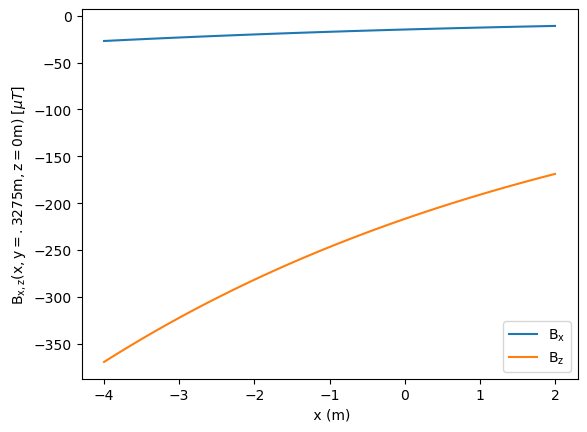

In [199]:
## A check, comparing to Takashi's work
#x, y=.3275, z=0
# Bx & B_z

plt.plot(B_dipole.x, B_dipole.Bx*1e6, label='$\mathsf{B_x}$')
plt.plot(B_dipole.x, B_dipole.Bz*1e6, label='$\mathsf{B_z}$')
plt.xlabel(' x (m)')
plt.ylabel('$\mathsf{B_{x,z}(x,y=.3275 m, z=0 m)} ~ [\mu T]$')
plt.legend()

plt.show()

In [163]:
import sys, os
sys.path.insert(1, '../MesonMagMapping/PrettyPlotTools/')
import ParticlePlottingFunctions as ppf
from stl import mesh
from mpl_toolkits import mplot3d

C:\Users\Emma\AppData\Local\Temp\ipykernel_14460\1952980827.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


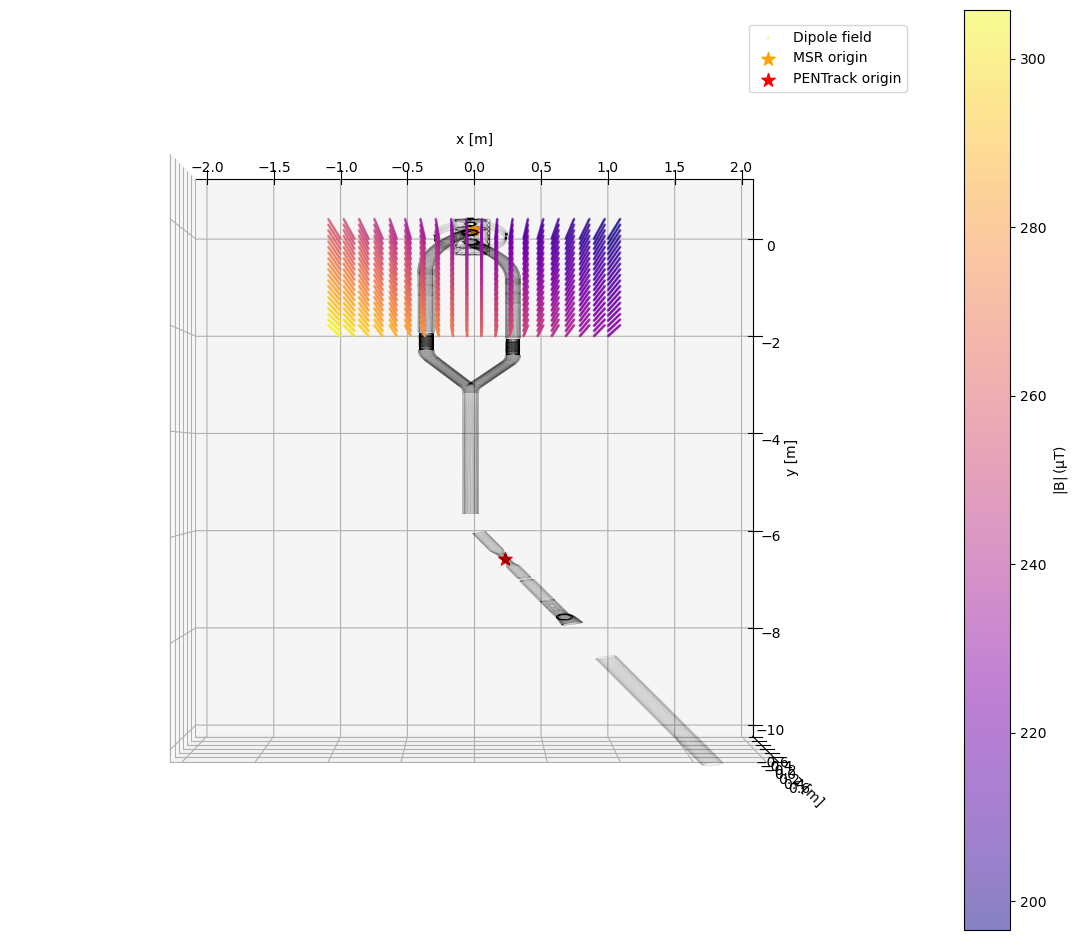

In [202]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# plt.title("2019 Magnetic field mapping", pad=-10)

# B1 = np.sqrt(data1[2]['B_x']**2 + data1[2]['B_y']**2 + data1[2]['B_z']**2 )*100 #muT
Q = axes.scatter(B_dipole['x'], B_dipole['y'], B_dipole['z'],
                            c=B_dipole['B']*1e6, s=1, alpha=0.5, cmap='plasma', label="Dipole field")
                    
#loads all the file I have in this folder as STLs
STLpath = '../MesonMagMapping/PrettyPlotTools/STLsToGraph_F_MSR'
stl_array = os.listdir(STLpath)

axes.scatter(0, 0, 0, marker="*", s=100, color="orange", label="MSR origin")
axes.scatter(0.223, -6.489, 0, marker="*", s=100, color="red", 
             label="PENTrack origin")

for STLfile in stl_array:
#     print(STLfile)
    ppf.graphSTL(STLpath+'/'+STLfile, axes)
    
# axes.view_init(elev=10., azim=45)
axes.view_init(elev=90., azim=-90) #top view
axes.set_xlim(-2, 2)
axes.set_ylim(-10, 1)
axes.set_zlim(-0.6, 0.6)

# cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,
#                     0.02,axes.get_position().height])
# fig.colorbar(Q, cax=cax) # Similar to fig.colorbar(im, cax = cax)

cbar = fig.colorbar(Q, label='$\mathsf{|B|\,(\mu T)}$', fraction=0.046)#, cax=cax)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

## SCM